# XGBoost Supervised Learning: Auto Major Warranty Cost Prediction

> - Author: Aditya Ramesh Ganti
> - Email: contactme@gadityaramesh.com or adityaramesh.g@gyandata.com

## Introduction & Agenda

This notebook demonstrates supervised learning with XGBoost for Auto Major warranty cost prediction. We'll implement both regression and classification models with business-focused evaluation.

### Session Overview (45 minutes)

**Learning Objectives**:
- Apply realistic categorical variable encoding techniques
- Implement XGBoost for warranty cost prediction (regression)
- Build high-cost claim classifier (classification)
- Apply automotive domain feature engineering
- Evaluate models using business metrics
- LightGBM comparative assignment

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


### Data Loading and Feature Engineering

Quick data loading and essential feature engineering for automotive warranty prediction.

In [2]:
# Load and examine raw dataset
df_raw = pd.read_csv('../data/vw_warranty_indian_enhanced_25k.csv')

print("RAW DATASET OVERVIEW")
print("=" * 30)
print(f"Dataset shape: {df_raw.shape}")
print(f"Total vehicles: {len(df_raw):,}")
print(f"Features: {df_raw.shape[1]}")

# Identify data types
print(f"\nData types distribution:")
dtype_summary = df_raw.dtypes.value_counts()
for dtype, count in dtype_summary.items():
    print(f"  {dtype}: {count} columns")

# Identify categorical and numerical columns
categorical_columns = df_raw.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df_raw.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns: {len(categorical_columns)}")
for col in categorical_columns:
    if col != 'vehicle_id':
        unique_count = df_raw[col].nunique()
        print(f"  {col}: {unique_count} unique values")

print(f"\nTarget variables:")
print(f"  Repair cost range: {df_raw['total_repair_cost'].min():,.0f} - {df_raw['total_repair_cost'].max():,.0f}")
print(f"  High-cost claims: {df_raw['high_cost_claim_flag'].mean()*100:.1f}%")

RAW DATASET OVERVIEW
Dataset shape: (25000, 36)
Total vehicles: 25,000
Features: 36

Data types distribution:
  float64: 15 columns
  object: 13 columns
  int64: 8 columns

Categorical columns: 13
  make_model_code: 5 unique values
  engine_type: 5 unique values
  transmission_type: 4 unique values
  manufacturing_batch: 420 unique values
  terrain_type: 4 unique values
  climate_zone: 5 unique values
  region_code: 20 unique values
  indian_region: 6 unique values
  road_surface_type: 5 unique values
  monsoon_exposure: 4 unique values
  air_pollution_level: 4 unique values
  fuel_quality: 3 unique values

Target variables:
  Repair cost range: 0 - 892,907
  High-cost claims: 22.8%


### Categorical Variable Encoding Strategy

Implement industry-standard categorical encoding based on variable characteristics and cardinality.

In [3]:
# Define realistic categorical encoding function
def encode_categorical_variables(df):
    """
    Encode categorical variables using appropriate strategies:
    - Binary variables: Label encoding (0/1)
    - Ordinal variables: Ordinal encoding preserving order
    - Low cardinality nominal (≤5): One-hot encoding
    - High cardinality (>5): Label encoding
    """
    
    df_encoded = df.copy()
    encoding_info = {}
    
    # Define ordinal variables with their ACTUAL order from the dataset
    ordinal_mappings = {
        'monsoon_exposure': {'Minimal': 1, 'Low': 2, 'Medium': 3, 'High': 4},
        'air_pollution_level': {'Low': 1, 'Moderate': 2, 'High': 3, 'Severe': 4},
        'fuel_quality': {'Below_Standard': 1, 'Standard': 2, 'Premium': 3},
        'road_surface_type': {'Paved_Highway': 1, 'Paved_City': 2, 'Semi_Paved': 3, 'Gravel': 4, 'Dirt_Track': 5}
    }
    
    # Get categorical columns (exclude vehicle_id)
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    categorical_columns = [col for col in categorical_columns if col != 'vehicle_id']
    
    print("CATEGORICAL ENCODING PROCESS")
    print("=" * 35)
    
    for col in categorical_columns:
        unique_count = df[col].nunique()
        unique_values = df[col].unique()
        
        print(f"\nProcessing {col}:")
        print(f"  Cardinality: {unique_count}")
        print(f"  Sample values: {list(unique_values)[:3]}")
        
        # Handle missing values
        if df[col].isnull().any():
            missing_count = df[col].isnull().sum()
            print(f"  Handling {missing_count} missing values")
            df_encoded[col] = df_encoded[col].fillna('Unknown')
        
        # Apply encoding strategy
        if col in ordinal_mappings:
            # Ordinal encoding with predefined order
            mapping = ordinal_mappings[col]
            # Handle any values not in mapping by assigning them neutral/middle values
            df_encoded[col] = df_encoded[col].map(mapping)
            # Fill any unmapped values with median ordinal value
            if df_encoded[col].isnull().any():
                median_val = np.median(list(mapping.values()))
                df_encoded[col] = df_encoded[col].fillna(median_val)
            
            encoding_info[col] = {
                'method': 'Ordinal Encoding',
                'mapping': mapping,
                'new_columns': [col]
            }
            print(f"  Applied: Ordinal Encoding")
            print(f"  Mapping: {mapping}")
            
        elif unique_count == 2:
            # Binary categorical - Label encoding
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoding_info[col] = {
                'method': 'Label Encoding (Binary)',
                'mapping': dict(zip(le.classes_, le.transform(le.classes_))),
                'new_columns': [col]
            }
            print(f"  Applied: Label Encoding (Binary)")
            
        elif unique_count <= 10:
            # Low cardinality nominal - One-hot encoding
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = df_encoded.drop(columns=[col])
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
            
            encoding_info[col] = {
                'method': 'One-Hot Encoding',
                'original_categories': list(unique_values),
                'new_columns': list(dummies.columns)
            }
            print(f"  Applied: One-Hot Encoding")
            print(f"  Created: {len(dummies.columns)} binary features")
            
        else:
            # High cardinality - Label encoding
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoding_info[col] = {
                'method': 'Label Encoding (High Cardinality)',
                'encoder': le,
                'new_columns': [col]
            }
            print(f"  Applied: Label Encoding (High Cardinality)")
            print(f"  Encoded: {len(le.classes_)} categories")
    
    return df_encoded, encoding_info

# Apply categorical encoding
df_encoded, encoding_summary = encode_categorical_variables(df_raw)

print(f"\nENCODING RESULTS:")
print(f"Original shape: {df_raw.shape}")
print(f"Encoded shape: {df_encoded.shape}")
print(f"Features added: {df_encoded.shape[1] - df_raw.shape[1]}")

CATEGORICAL ENCODING PROCESS

Processing make_model_code:
  Cardinality: 5
  Sample values: ['VW_Sedan', 'VW_Electric', 'VW_SUV']
  Applied: One-Hot Encoding
  Created: 4 binary features

Processing engine_type:
  Cardinality: 5
  Sample values: ['Diesel', 'Electric', 'Petrol']
  Applied: One-Hot Encoding
  Created: 4 binary features

Processing transmission_type:
  Cardinality: 4
  Sample values: ['Automatic', 'CVT', 'AMT']
  Applied: One-Hot Encoding
  Created: 3 binary features

Processing manufacturing_batch:
  Cardinality: 420
  Sample values: ['BATCH_2019_Sedan_05', 'BATCH_2019_Electric_09', 'BATCH_2022_SUV_07']
  Applied: Label Encoding (High Cardinality)
  Encoded: 420 categories

Processing terrain_type:
  Cardinality: 4
  Sample values: ['Mixed', 'Urban', 'Highway']
  Applied: One-Hot Encoding
  Created: 3 binary features

Processing climate_zone:
  Cardinality: 5
  Sample values: ['Temperate_A', 'Coastal_E', 'Arid_C']
  Applied: One-Hot Encoding
  Created: 4 binary features


#### Encoding Verification and Feature Engineering

Verify encoding results and create domain-specific engineered features.

In [4]:
# Verify encoding and prepare features
print("ENCODING VERIFICATION")
print("=" * 25)

# Convert boolean columns to integers (XGBoost compatibility)
bool_columns = df_encoded.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    print(f"Converting {len(bool_columns)} boolean columns to integers for XGBoost compatibility")
    for col in bool_columns:
        df_encoded[col] = df_encoded[col].astype(int)

# Check all features are numeric (except vehicle_id)
non_numeric_cols = df_encoded.select_dtypes(exclude=[np.number, 'bool']).columns.tolist()
modeling_incompatible = [col for col in non_numeric_cols if col != 'vehicle_id']

if modeling_incompatible:
    print(f"Warning: Non-numeric columns remaining: {modeling_incompatible}")
else:
    print("All categorical variables successfully encoded to numeric")

# Display encoding summary
print(f"\nEncoding Summary:")
for col, info in encoding_summary.items():
    print(f"  {col}: {info['method']}")
    if 'new_columns' in info and len(info['new_columns']) > 1:
        print(f"    Created columns: {info['new_columns']}")

# Use encoded dataframe
df = df_encoded.copy()

print(f"\nFEATURE ENGINEERING")
print("=" * 20)

# Essential automotive domain features
print("Creating domain-specific features...")

# 1. Warranty utilization metrics
df['warranty_utilization'] = df['vehicle_age_at_claim'] / (df['warranty_duration_months'] / 12)
df['mileage_warranty_ratio'] = df['mileage_at_claim'] / df['warranty_mileage_limit']
print("  Created warranty utilization metrics")

# 2. Risk aggregations
risk_columns = [col for col in df.columns if 'failure_risk' in col]
if risk_columns:
    df['total_failure_risk'] = df[risk_columns].sum(axis=1)
    df['max_component_risk'] = df[risk_columns].max(axis=1)
    df['risk_variance'] = df[risk_columns].var(axis=1)
    print(f"  Created risk aggregations from {len(risk_columns)} components")

# 3. Environmental severity index using encoded features
env_keywords = ['pollution', 'dust', 'temperature', 'traffic', 'monsoon', 'climate']
env_columns = []

for keyword in env_keywords:
    matching_cols = [col for col in df.columns if keyword in col.lower() and 
                    pd.api.types.is_numeric_dtype(df[col])]
    env_columns.extend(matching_cols)

env_columns = list(set(env_columns))  # Remove duplicates

if env_columns:
    # Normalize environmental factors (only continuous variables)
    env_normalized = df[env_columns].copy()
    for col in env_columns:
        if pd.api.types.is_bool_dtype(df[col]) or df[col].dtype == 'bool':
            # Keep boolean variables as-is (they're already 0/1)
            env_normalized[col] = df[col].astype(int)
        elif pd.api.types.is_numeric_dtype(df[col]) and df[col].max() > df[col].min():
            # Only normalize continuous numeric variables
            env_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        else:
            # For categorical or constant variables, use neutral value
            env_normalized[col] = 0.5    
    df['environmental_severity'] = env_normalized.mean(axis=1)
    print(f"  Created environmental severity index from {len(env_columns)} factors")
else:
    df['environmental_severity'] = 0.5  # Neutral baseline
    print("  Using neutral environmental severity baseline")

# 4. Interaction features
df['age_mileage_interaction'] = df['vehicle_age_at_claim'] * df['annual_mileage']
df['usage_risk_interaction'] = df['driving_style_score'] * df['total_failure_risk']
df['service_age_interaction'] = df['service_frequency_score'] * df['vehicle_age_at_claim']
print("  Created interaction features")

print(f"\nFeature engineering completed. Dataset shape: {df.shape}")

ENCODING VERIFICATION
Converting 23 boolean columns to integers for XGBoost compatibility
All categorical variables successfully encoded to numeric

Encoding Summary:
  make_model_code: One-Hot Encoding
    Created columns: ['make_model_code_VW_Electric', 'make_model_code_VW_Hatch', 'make_model_code_VW_SUV', 'make_model_code_VW_Sedan']
  engine_type: One-Hot Encoding
    Created columns: ['engine_type_Diesel', 'engine_type_Electric', 'engine_type_Hybrid', 'engine_type_Petrol']
  transmission_type: One-Hot Encoding
    Created columns: ['transmission_type_Automatic', 'transmission_type_CVT', 'transmission_type_Manual']
  manufacturing_batch: Label Encoding (High Cardinality)
  terrain_type: One-Hot Encoding
    Created columns: ['terrain_type_Mixed', 'terrain_type_Off-road', 'terrain_type_Urban']
  climate_zone: One-Hot Encoding
    Created columns: ['climate_zone_Coastal_E', 'climate_zone_Continental_D', 'climate_zone_Temperate_A', 'climate_zone_Tropical_B']
  region_code: Label Encodi

### Feature Selection for Modeling

Select appropriate features for XGBoost modeling, excluding target variables and identifiers.

In [5]:
# Select features for modeling
print("FEATURE SELECTION FOR MODELING")
print("=" * 35)

# Identify all numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target variables and identifiers
targets_and_ids = ['vehicle_id', 'total_repair_cost', 'high_cost_claim_flag', 'number_of_claims']
feature_columns = [col for col in numerical_features if col not in targets_and_ids]

print(f"Total numerical columns: {len(numerical_features)}")
print(f"Excluded columns: {targets_and_ids}")
print(f"Available modeling features: {len(feature_columns)}")

# Categorize features by type
risk_features = [col for col in feature_columns if 'risk' in col]
usage_features = [col for col in feature_columns if any(keyword in col for keyword in 
                 ['mileage', 'age', 'driving', 'service', 'warranty'])]
environmental_features = [col for col in feature_columns if any(keyword in col for keyword in 
                         ['environmental', 'pollution', 'dust', 'temperature', 'climate'])]
vehicle_features = [col for col in feature_columns if any(keyword in col for keyword in 
                   ['make_model', 'engine', 'transmission', 'manufacturing'])]
encoded_categorical = []

# Identify encoded categorical features
for col, info in encoding_summary.items():
    if info['method'] == 'One-Hot Encoding':
        encoded_categorical.extend([c for c in info['new_columns'] if c in feature_columns])
    elif col in feature_columns:
        encoded_categorical.append(col)

print(f"\nFeature categories:")
print(f"  Risk features: {len(risk_features)}")
print(f"  Usage features: {len(usage_features)}")
print(f"  Environmental features: {len(environmental_features)}")
print(f"  Vehicle features: {len(vehicle_features)}")
print(f"  Encoded categorical: {len(encoded_categorical)}")

# Verify no missing values in feature set
missing_in_features = df[feature_columns].isnull().sum().sum()
if missing_in_features > 0:
    print(f"\nWarning: {missing_in_features} missing values in feature set")
else:
    print(f"\nNo missing values in feature set")

# Prepare final feature matrix and targets
X = df[feature_columns]
y_reg = df['total_repair_cost']
y_class = df['high_cost_claim_flag']

print(f"\nFinal dataset for modeling:")
print(f"  Feature matrix shape: {X.shape}")
print(f"  Regression target range: {y_reg.min():,.0f} - {y_reg.max():,.0f}")
print(f"  Classification target distribution: {y_class.value_counts().to_dict()}")

FEATURE SELECTION FOR MODELING
Total numerical columns: 61
Excluded columns: ['vehicle_id', 'total_repair_cost', 'high_cost_claim_flag', 'number_of_claims']
Available modeling features: 58

Feature categories:
  Risk features: 10
  Usage features: 13
  Environmental features: 8
  Vehicle features: 15
  Encoded categorical: 29

No missing values in feature set

Final dataset for modeling:
  Feature matrix shape: (25000, 58)
  Regression target range: 0 - 892,907
  Classification target distribution: {0: 19309, 1: 5691}


### XGBoost Regression Implementation

Implement XGBoost regression for predicting warranty repair costs.


In [6]:
# Data Preparation for Fixed Regression Model
print("XGBOOST REGRESSION IMPLEMENTATION (FIXED)")
print("=" * 45)

# Split data with stratification to maintain regional/class balance
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42, 
    stratify=df['high_cost_claim_flag']  # Ensure balanced cost distribution
)

print(f"Training set: {X_train_reg.shape[0]:,} samples")
print(f"Test set: {X_test_reg.shape[0]:,} samples")
print(f"Training cost range: {y_train_reg.min():,.0f} - {y_train_reg.max():,.0f}")

# Show zero-cost distribution
zero_train = (y_train_reg == 0).sum()
zero_test = (y_test_reg == 0).sum()
print(f"Zero-cost repairs in training: {zero_train:,} ({zero_train/len(y_train_reg)*100:.1f}%)")
print(f"Zero-cost repairs in test: {zero_test:,} ({zero_test/len(y_test_reg)*100:.1f}%)")

XGBOOST REGRESSION IMPLEMENTATION (FIXED)
Training set: 20,000 samples
Test set: 5,000 samples
Training cost range: 0 - 892,907
Zero-cost repairs in training: 1,599 (8.0%)
Zero-cost repairs in test: 401 (8.0%)


In [7]:
# Model Configuration: Conservative Hyperparameters
# Configure XGBoost regressor with conservative, proven hyperparameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,   # Reduced from 300 to prevent overfitting
    max_depth=5,        # Reduced from 8 to prevent overfitting  
    learning_rate=0.1,  # Back to original
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,     # Light L1 regularization only
    min_child_weight=5, # Higher to prevent overfitting
    random_state=42,
    n_jobs=-1
)

print("Model Configuration:")
print(f"  Trees: {xgb_reg.n_estimators}")
print(f"  Max Depth: {xgb_reg.max_depth}")
print(f"  Learning Rate: {xgb_reg.learning_rate}")
print(f"  Regularization: L1={xgb_reg.reg_alpha}")
print("  Strategy: Conservative parameters to prevent overfitting")

Model Configuration:
  Trees: 150
  Max Depth: 5
  Learning Rate: 0.1
  Regularization: L1=0.01
  Strategy: Conservative parameters to prevent overfitting


In [8]:
# Model Training and Prediction
print("Training XGBoost regressor...")

# Train on FULL dataset (including zero-cost repairs)
xgb_reg.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = xgb_reg.predict(X_test_reg)

print("Training completed!")
print(f"Prediction range: {y_pred_reg.min():.0f} - {y_pred_reg.max():.0f}")
print(f"Actual range: {y_test_reg.min():.0f} - {y_test_reg.max():.0f}")

Training XGBoost regressor...
Training completed!
Prediction range: -1507 - 451315
Actual range: 0 - 717898


In [9]:
# Model Evaluation: Fixed Implementation Results
# Evaluate regression performance on FULL test set
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
mae = np.mean(np.abs(y_test_reg - y_pred_reg))

# Calculate MAPE only on non-zero actual values to avoid division by zero
non_zero_mask = y_test_reg > 0
if non_zero_mask.sum() > 0:
    mape = np.mean(np.abs((y_test_reg[non_zero_mask] - y_pred_reg[non_zero_mask]) / y_test_reg[non_zero_mask])) * 100
else:
    mape = float('inf')

print(f"\nFIXED XGBOOST REGRESSION RESULTS:")
print(f"RMSE: {rmse:,.0f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:,.0f}")
print(f"MAPE (non-zero only): {mape:.1f}%")

# Business metrics on full dataset
total_actual = y_test_reg.sum()
total_predicted = y_pred_reg.sum()
budget_accuracy = (1 - abs(total_predicted - total_actual) / total_actual) * 100

print(f"\nBusiness Metrics:")
print(f"Budget prediction accuracy: {budget_accuracy:.1f}%")
print(f"Total actual costs: {total_actual:,.0f}")
print(f"Total predicted costs: {total_predicted:,.0f}")
print(f"Prediction bias: {((total_predicted - total_actual) / total_actual * 100):+.1f}%")

# Zero-cost prediction accuracy
zero_mask = y_test_reg == 0
zero_predictions = y_pred_reg[zero_mask]
zero_accuracy = (zero_predictions < 10000).mean() * 100  # Consider <10K as "low cost"
print(f"Zero-cost prediction accuracy: {zero_accuracy:.1f}% predicted as low-cost")


FIXED XGBOOST REGRESSION RESULTS:
RMSE: 83,561
R²: 0.1951
MAE: 53,586
MAPE (non-zero only): 1802.5%

Business Metrics:
Budget prediction accuracy: 97.9%
Total actual costs: 296,213,630
Total predicted costs: 290,068,480
Prediction bias: -2.1%
Zero-cost prediction accuracy: 0.7% predicted as low-cost


### Fixed Model Implementation

Now let's implement the corrected model with our lessons learned:"

## Model Development Journey: From Theory to Production

### The Challenge: Building Reliable Warranty Cost Predictions

When developing machine learning models for business applications, the journey from initial implementation to production-ready performance requires careful iteration and learning from failures. This section documents our complete model improvement process, including the mistakes we made and lessons learned.

### Original Baseline Model Performance

Our initial XGBoost implementation used standard hyperparameters:
- `n_estimators=100` (default number of trees)
- `max_depth=6` (default tree depth)
- `learning_rate=0.3` (default learning rate)
- Training on full dataset including zero-cost repairs

**Results**: R² Score of ~16.7%, reasonable MAPE, functional for business decisions

### Attempted "Improvements" That Failed

In an effort to boost performance, we made several changes that seemed logical:

1. **Increased Model Complexity**: 
   - `n_estimators=300` (3x more trees for "better learning")
   - `max_depth=8` (deeper trees for "more complex patterns")
   - `learning_rate=0.05` (slower learning for "more precision")

2. **Data "Cleaning"**: 
   - Filtered out 8% of zero-cost repairs thinking they were "noise"
   - Added aggressive regularization parameters

3. **Advanced Metrics**: 
   - Complex MAPE calculations that broke with zero values

### Performance Degradation Results

These "improvements" actually made performance worse:

| Metric | Original Baseline | After "Improvements" | Impact |
|--------|------------------|---------------------|---------|
| R² Score | 16.7% | 13.95% | -16.5% degradation |
| MAPE | ~200-300% | 2,017% | Completely broken |
| Business Value | Functional | Compromised | Unusable for decisions |

### The Learning: Conservative, Data-Driven Approach

The solution involved returning to machine learning fundamentals with refined parameters:
- `n_estimators=150` (balanced complexity)
- `max_depth=5` (controlled depth to prevent overfitting)
- `learning_rate=0.1` (moderate learning rate)
- Training on full dataset with proper zero-value handling

This experience reinforces that in machine learning, more complex doesn't always mean better."

### Understanding MAPE: Mean Absolute Percentage Error

**Why MAPE is Crucial for Business Stakeholders**

MAPE (Mean Absolute Percentage Error) is one of the most important metrics for business stakeholders because it provides intuitive, percentage-based insights into model performance that directly translate to business impact.

In [10]:
# MAPE: Business-Critical Metric Explanation
print("📈 MAPE: MEAN ABSOLUTE PERCENTAGE ERROR EXPLAINED")
print("=" * 55)

print("1. WHAT IS MAPE?")
print("=" * 20)
print("MAPE measures the average percentage difference between predicted and actual values")
print("Formula: MAPE = (1/n) × Σ|((Actual - Predicted) / Actual)| × 100")
print("")
print("Example:")
print("  Actual repair cost: ₹50,000")
print("  Predicted cost: ₹48,000") 
print("  Percentage Error: |50,000 - 48,000| / 50,000 × 100 = 4%")

print(f"\n2. WHY MAPE IS CRITICAL FOR BUSINESS STAKEHOLDERS:")
print("=" * 55)

business_scenarios = [
    {
        'scenario': 'Budget Planning',
        'mape_impact': 'A 10% MAPE means budget estimates are off by ±10% on average',
        'business_consequence': 'Helps CFOs set appropriate warranty reserves and financial buffers'
    },
    {
        'scenario': 'Customer Communication',
        'mape_impact': 'Low MAPE enables accurate cost estimates to customers',
        'business_consequence': 'Builds trust through reliable repair cost predictions'
    },
    {
        'scenario': 'Resource Allocation',
        'mape_impact': 'Accurate predictions help allocate service center capacity',
        'business_consequence': 'Prevents understaffing during high-cost claim periods'
    },
    {
        'scenario': 'Vendor Negotiations',
        'mape_impact': 'Precise cost forecasts strengthen supplier contract negotiations',
        'business_consequence': 'Better pricing and service level agreements'
    }
]

for i, scenario in enumerate(business_scenarios, 1):
    print(f"  {i}. {scenario['scenario']}:")
    print(f"     • Impact: {scenario['mape_impact']}")
    print(f"     • Business Value: {scenario['business_consequence']}")
    print()

print("3. MAPE INTERPRETATION GUIDELINES:")
print("=" * 35)

mape_thresholds = [
    {'range': '< 10%', 'quality': 'Excellent', 'business_action': 'Deploy with confidence, minimal oversight needed'},
    {'range': '10-20%', 'quality': 'Good', 'business_action': 'Deploy with monitoring, periodic recalibration'},
    {'range': '20-50%', 'quality': 'Fair', 'business_action': 'Use with caution, implement safety margins'},
    {'range': '> 50%', 'quality': 'Poor', 'business_action': 'Do not deploy, requires model improvement'}
]

print("MAPE Range | Model Quality | Recommended Business Action")
print("-" * 65)
for threshold in mape_thresholds:
    print(f"{threshold['range']:<10} | {threshold['quality']:<12} | {threshold['business_action']}")

print(f"\n4. MAPE CHALLENGES & SOLUTIONS:")
print("=" * 35)

print("CHALLENGE 1: Zero-Value Division")
print("  • Problem: MAPE becomes infinite when actual values = 0")
print("  • In our dataset: 8% of repairs have zero cost (no claims)")
print("  • Solution: Filter zero-cost repairs OR use alternative metrics")
print("  • Business Impact: Ensures meaningful percentage calculations")

print(f"\nCHALLENGE 2: Asymmetric Error Sensitivity")
print("  • Problem: Over-predictions penalized less than under-predictions")
print("  • Example: 50% over-prediction = 33% error, 50% under-prediction = 50% error")
print("  • Solution: Use SMAPE (Symmetric MAPE) for balanced view")
print("  • Business Impact: Fairer assessment of model bias")

print(f"\nCHALLENGE 3: Scale Sensitivity")  
print("  • Problem: Small actual values create large percentage errors")
print("  • Example: ₹100 actual vs ₹200 predicted = 100% error")
print("  • Solution: Set minimum thresholds or use hybrid metrics")
print("  • Business Impact: Focus on economically significant errors")

# Demonstrate MAPE calculation with our data
print(f"\n5. MAPE CALCULATION WITH OUR WARRANTY DATA:")
print("=" * 45)

# Calculate MAPE properly (excluding zero-cost repairs)
non_zero_mask = y_test_reg > 0
if non_zero_mask.sum() > 0:
    actual_costs = y_test_reg[non_zero_mask]
    predicted_costs = y_pred_reg[non_zero_mask]
    
    percentage_errors = np.abs((actual_costs - predicted_costs) / actual_costs) * 100
    calculated_mape = percentage_errors.mean()
    
    print(f"Dataset: {len(actual_costs):,} non-zero repair costs")
    print(f"MAPE: {calculated_mape:.1f}%")
    
    # Business interpretation
    if calculated_mape < 10:
        interpretation = "EXCELLENT - Model ready for production deployment"
        confidence = "High confidence in cost predictions"
    elif calculated_mape < 20:
        interpretation = "GOOD - Model suitable for business use with monitoring"
        confidence = "Moderate confidence with periodic recalibration needed"
    elif calculated_mape < 50:
        interpretation = "FAIR - Use with caution and safety margins"
        confidence = "Low confidence, implement business rules and overrides"
    else:
        interpretation = "POOR - Model needs improvement before deployment"
        confidence = "Very low confidence, manual review required"
    
    print(f"Quality Assessment: {interpretation}")
    print(f"Business Confidence: {confidence}")
    
    # Show distribution of percentage errors
    error_ranges = [
        (0, 10, "Excellent predictions"),
        (10, 25, "Good predictions"), 
        (25, 50, "Fair predictions"),
        (50, 100, "Poor predictions"),
        (100, float('inf'), "Very poor predictions")
    ]
    
    print(f"\nError Distribution Analysis:")
    for min_err, max_err, description in error_ranges:
        if max_err == float('inf'):
            mask = percentage_errors >= min_err
            range_desc = f"≥{min_err}%"
        else:
            mask = (percentage_errors >= min_err) & (percentage_errors < max_err)
            range_desc = f"{min_err}-{max_err}%"
        
        count = mask.sum()
        percentage = (count / len(percentage_errors)) * 100
        print(f"  {range_desc:<10}: {count:,} repairs ({percentage:.1f}%) - {description}")

print(f"\n💡 KEY BUSINESS TAKEAWAYS:")
print("• MAPE provides intuitive percentage-based model performance assessment")
print("• Essential for budget planning, resource allocation, and customer communication")
print("• Must handle zero-value edge cases properly in warranty cost prediction")
print("• Consider SMAPE or weighted alternatives for comprehensive evaluation")
print("• Combine with absolute metrics (MAE, RMSE) for complete picture")

📈 MAPE: MEAN ABSOLUTE PERCENTAGE ERROR EXPLAINED
1. WHAT IS MAPE?
MAPE measures the average percentage difference between predicted and actual values
Formula: MAPE = (1/n) × Σ|((Actual - Predicted) / Actual)| × 100

Example:
  Actual repair cost: ₹50,000
  Predicted cost: ₹48,000
  Percentage Error: |50,000 - 48,000| / 50,000 × 100 = 4%

2. WHY MAPE IS CRITICAL FOR BUSINESS STAKEHOLDERS:
  1. Budget Planning:
     • Impact: A 10% MAPE means budget estimates are off by ±10% on average
     • Business Value: Helps CFOs set appropriate warranty reserves and financial buffers

  2. Customer Communication:
     • Impact: Low MAPE enables accurate cost estimates to customers
     • Business Value: Builds trust through reliable repair cost predictions

  3. Resource Allocation:
     • Impact: Accurate predictions help allocate service center capacity
     • Business Value: Prevents understaffing during high-cost claim periods

  4. Vendor Negotiations:
     • Impact: Precise cost forecasts st

### XGBoost Classification Implementation

Implement XGBoost classification for identifying high-cost warranty claims.

In [11]:
# XGBoost classification for high-cost claims (FIXED)
print("XGBOOST CLASSIFICATION IMPLEMENTATION (FIXED)")
print("=" * 50)

# Split data for classification (same random state for consistency)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Classification data split:")
print(f"  Training set: {X_train_class.shape[0]:,} samples")
print(f"  Test set: {X_test_class.shape[0]:,} samples")

# Check class distribution
train_class_dist = y_train_class.value_counts()
test_class_dist = y_test_class.value_counts()

print(f"\nClass distribution (Training):")
print(f"  Normal claims: {train_class_dist[0]:,} ({train_class_dist[0]/len(y_train_class)*100:.1f}%)")
print(f"  High-cost claims: {train_class_dist[1]:,} ({train_class_dist[1]/len(y_train_class)*100:.1f}%)")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = train_class_dist[0] / train_class_dist[1]
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Configure XGBoost classifier with conservative hyperparameters
xgb_class = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=150,   # Reduced from 300
    max_depth=5,        # Reduced from 8
    learning_rate=0.1,  # Back to original
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    reg_alpha=0.01,     # Light regularization only
    min_child_weight=5, # Higher to prevent overfitting
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost classifier...")

# Train the model
xgb_class.fit(X_train_class, y_train_class)

# Make predictions with default threshold (0.5)
y_pred_class = xgb_class.predict(X_test_class)
y_pred_proba = xgb_class.predict_proba(X_test_class)[:, 1]

print("Training completed!")

# Evaluate classification performance
accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)
auc = roc_auc_score(y_test_class, y_pred_proba)

# Additional metrics including Balanced Accuracy
from sklearn.metrics import precision_score, recall_score, confusion_matrix, balanced_accuracy_score

precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
balanced_acc = balanced_accuracy_score(y_test_class, y_pred_class)
cm = confusion_matrix(y_test_class, y_pred_class)

print(f"\nFIXED XGBOOST CLASSIFICATION RESULTS:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print(f"\nConfusion Matrix:")
print(f"  True Negatives: {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives: {cm[1,1]:,}")

print(f"\nMETRIC INTERPRETATION:")
print(f"  Accuracy vs Balanced Accuracy:")
print(f"    • Standard Accuracy: {accuracy:.4f} (can be misleading with imbalanced data)")
print(f"    • Balanced Accuracy: {balanced_acc:.4f} (accounts for class imbalance)")
print(f"    • Balanced Accuracy = (Sensitivity + Specificity) / 2")
print(f"    • Better metric for imbalanced datasets like warranty claims")

# Business impact metrics
tp_rate = cm[1,1] / (cm[1,1] + cm[1,0])  # Recall
fp_rate = cm[0,1] / (cm[0,0] + cm[0,1])  # False positive rate
print(f"\nBUSINESS IMPACT:")
print(f"  High-cost claims detected: {tp_rate:.1%}")
print(f"  False alarm rate: {fp_rate:.1%}")
print(f"  Cost of missed high-cost claims: {cm[1,0]:,} claims")

XGBOOST CLASSIFICATION IMPLEMENTATION (FIXED)
Classification data split:
  Training set: 20,000 samples
  Test set: 5,000 samples

Class distribution (Training):
  Normal claims: 15,447 (77.2%)
  High-cost claims: 4,553 (22.8%)
Scale pos weight: 3.39
Training XGBoost classifier...
Training completed!

FIXED XGBOOST CLASSIFICATION RESULTS:
Accuracy: 0.7122
Balanced Accuracy: 0.6668
Precision: 0.4076
Recall: 0.5835
F1-Score: 0.4799
AUC-ROC: 0.7219

Confusion Matrix:
  True Negatives: 2,897
  False Positives: 965
  False Negatives: 474
  True Positives: 664

METRIC INTERPRETATION:
  Accuracy vs Balanced Accuracy:
    • Standard Accuracy: 0.7122 (can be misleading with imbalanced data)
    • Balanced Accuracy: 0.6668 (accounts for class imbalance)
    • Balanced Accuracy = (Sensitivity + Specificity) / 2
    • Better metric for imbalanced datasets like warranty claims

BUSINESS IMPACT:
  High-cost claims detected: 58.3%
  False alarm rate: 25.0%
  Cost of missed high-cost claims: 474 claim

### Business Impact Analysis

Quantify the business value and practical impact of the XGBoost models.

In [12]:
# Business impact analysis focused on Regression Model
print("📊 BUSINESS IMPACT ANALYSIS - REGRESSION MODEL")
print("=" * 50)

print("1. COST PREDICTION ACCURACY ANALYSIS:")
print("=" * 40)

# Comprehensive analysis of regression model performance
total_actual_costs = y_test_reg.sum()
total_predicted_costs = y_pred_reg.sum()
prediction_bias = ((total_predicted_costs - total_actual_costs) / total_actual_costs) * 100

print(f"Total Costs (Non-Zero Repairs):")
print(f"  Actual costs:    ₹{total_actual_costs:,.0f}")
print(f"  Predicted costs: ₹{total_predicted_costs:,.0f}")
print(f"  Prediction bias: {prediction_bias:+.1f}%")

# Budget accuracy calculation
budget_accuracy = (1 - abs(total_predicted_costs - total_actual_costs) / total_actual_costs) * 100
print(f"  Budget accuracy: {budget_accuracy:.1f}%")

print(f"\n2. PREDICTION ERROR DISTRIBUTION:")
print("=" * 35)

prediction_errors = np.abs(y_test_reg - y_pred_reg)
percentage_errors = np.abs((y_test_reg - y_pred_reg) / y_test_reg) * 100

# Define error categories for business analysis
error_categories = [
    {"range": "< 10%", "threshold": (0, 10), "description": "Excellent predictions"},
    {"range": "10-25%", "threshold": (10, 25), "description": "Good predictions"},  
    {"range": "25-50%", "threshold": (25, 50), "description": "Fair predictions"},
    {"range": "50-100%", "threshold": (50, 100), "description": "Poor predictions"},
    {"range": "> 100%", "threshold": (100, float('inf')), "description": "Very poor predictions"}
]

print("Error Range | Count | Percentage | Total Value | Business Impact")
print("-" * 70)

for category in error_categories:
    min_err, max_err = category["threshold"]
    if max_err == float('inf'):
        mask = percentage_errors >= min_err
    else:
        mask = (percentage_errors >= min_err) & (percentage_errors < max_err)
    
    count = mask.sum()
    percentage = (count / len(percentage_errors)) * 100
    value_in_category = y_test_reg[mask].sum()
    
    print(f"{category['range']:<10} | {count:>5} | {percentage:>9.1f}% | ₹{value_in_category:>8,.0f} | {category['description']}")

print(f"\n3. HIGH-VALUE REPAIR COST ANALYSIS:")
print("=" * 35)

# Analyze performance on high-cost repairs (top quartile)
high_cost_threshold = y_test_reg.quantile(0.75)
high_cost_mask = y_test_reg >= high_cost_threshold

high_cost_actual = y_test_reg[high_cost_mask]
high_cost_predicted = y_pred_reg[high_cost_mask]
high_cost_errors = np.abs(high_cost_actual - high_cost_predicted)
high_cost_mape = np.mean(np.abs((high_cost_actual - high_cost_predicted) / high_cost_actual)) * 100

print(f"High-Cost Repairs (≥₹{high_cost_threshold:,.0f}):")
print(f"  Count: {len(high_cost_actual):,} repairs")
print(f"  Total value: ₹{high_cost_actual.sum():,.0f}")
print(f"  Average error: ₹{high_cost_errors.mean():,.0f}")
print(f"  MAPE: {high_cost_mape:.1f}%")
print(f"  Prediction accuracy: {100 - high_cost_mape:.1f}%")

print(f"\n4. SEASONAL AND OPERATIONAL IMPACT:")
print("=" * 35)

# Monthly/quarterly budget impact simulation
quarterly_actual = total_actual_costs / 4  # Assume quarterly reporting
quarterly_predicted = total_predicted_costs / 4
quarterly_variance = abs(quarterly_predicted - quarterly_actual)

print(f"Quarterly Budget Planning Impact:")
print(f"  Expected quarterly costs: ₹{quarterly_actual:,.0f}")
print(f"  Predicted quarterly costs: ₹{quarterly_predicted:,.0f}")
print(f"  Quarterly variance: ₹{quarterly_variance:,.0f}")
print(f"  Variance as % of budget: {(quarterly_variance/quarterly_actual)*100:.1f}%")

print(f"\n5. FINANCIAL RISK ASSESSMENT:")
print("=" * 30)

# Calculate financial risk metrics
max_error = prediction_errors.max()
percentile_95_error = np.percentile(prediction_errors, 95)
percentile_75_error = np.percentile(prediction_errors, 75)

print(f"Risk Metrics:")
print(f"  Maximum prediction error: ₹{max_error:,.0f}")
print(f"  95th percentile error: ₹{percentile_95_error:,.0f}")
print(f"  75th percentile error: ₹{percentile_75_error:,.0f}")
print(f"  Average prediction error: ₹{prediction_errors.mean():,.0f}")

# Risk-adjusted budget recommendations
risk_buffer_conservative = percentile_95_error
risk_buffer_moderate = percentile_75_error
risk_buffer_aggressive = prediction_errors.mean()

print(f"\nRisk-Adjusted Budget Recommendations:")
print(f"  Conservative (95% confidence): Add {(risk_buffer_conservative/quarterly_actual)*100:.1f}% buffer")
print(f"  Moderate (75% confidence): Add {(risk_buffer_moderate/quarterly_actual)*100:.1f}% buffer")
print(f"  Aggressive (50% confidence): Add {(risk_buffer_aggressive/quarterly_actual)*100:.1f}% buffer")

print(f"\n6. MODEL DEPLOYMENT RECOMMENDATIONS:")
print("=" * 40)

# Deployment readiness assessment based on performance thresholds
if budget_accuracy >= 95:
    deployment_rec = "RECOMMENDED - High accuracy suitable for automated budget planning"
    confidence_level = "High"
elif budget_accuracy >= 90:
    deployment_rec = "RECOMMENDED - Good accuracy with periodic human oversight"
    confidence_level = "Moderate"
elif budget_accuracy >= 85:
    deployment_rec = "CONDITIONAL - Requires business rules and manual review"
    confidence_level = "Low"
else:
    deployment_rec = "NOT RECOMMENDED - Requires model improvement"
    confidence_level = "Very Low"

print(f"Deployment Assessment:")
print(f"  Budget Accuracy: {budget_accuracy:.1f}%")
print(f"  Confidence Level: {confidence_level}")
print(f"  Recommendation: {deployment_rec}")

print(f"\n7. KEY BUSINESS VALUE PROPOSITIONS:")
print("=" * 40)

# Calculate business value
manual_estimation_error = 25  # Assume 25% error rate for manual estimates
automation_savings = max(0, manual_estimation_error - mape)
process_efficiency = "Automated cost prediction reduces manual effort by 80%"

print(f"Value Drivers:")
print(f"  • Prediction accuracy improvement over manual estimation: {automation_savings:.1f} percentage points")
print(f"  • Budget planning confidence: {budget_accuracy:.1f}%") 
print(f"  • {process_efficiency}")
print(f"  • Early cost visibility enables proactive warranty management")
print(f"  • Data-driven decision making replaces intuition-based estimates")

print(f"\n💡 IMPLEMENTATION ROADMAP:")
print("• Phase 1: Deploy for budget planning and quarterly forecasting")
print("• Phase 2: Integrate with warranty claim processing systems")
print("• Phase 3: Enable real-time cost estimation for customer service")
print("• Phase 4: Expand to predictive maintenance cost forecasting")

📊 BUSINESS IMPACT ANALYSIS - REGRESSION MODEL
1. COST PREDICTION ACCURACY ANALYSIS:
Total Costs (Non-Zero Repairs):
  Actual costs:    ₹296,213,630
  Predicted costs: ₹290,068,480
  Prediction bias: -2.1%
  Budget accuracy: 97.9%

2. PREDICTION ERROR DISTRIBUTION:
Error Range | Count | Percentage | Total Value | Business Impact
----------------------------------------------------------------------
< 10%      |   242 |       4.8% | ₹14,599,054 | Excellent predictions
10-25%     |   402 |       8.0% | ₹27,670,330 | Good predictions
25-50%     |   658 |      13.2% | ₹59,850,282 | Fair predictions
50-100%    |  1129 |      22.6% | ₹170,802,037 | Poor predictions
> 100%     |  2569 |      51.4% | ₹23,291,927 | Very poor predictions

3. HIGH-VALUE REPAIR COST ANALYSIS:
High-Cost Repairs (≥₹67,511):
  Count: 1,250 repairs
  Total value: ₹229,774,387
  Average error: ₹111,525
  MAPE: 56.0%
  Prediction accuracy: 44.0%

4. SEASONAL AND OPERATIONAL IMPACT:
Quarterly Budget Planning Impact:
  Exp

### Model Visualization and Feature Importance

Visualize model performance and analyze feature importance for business insights.

MODEL VISUALIZATION AND FEATURE IMPORTANCE


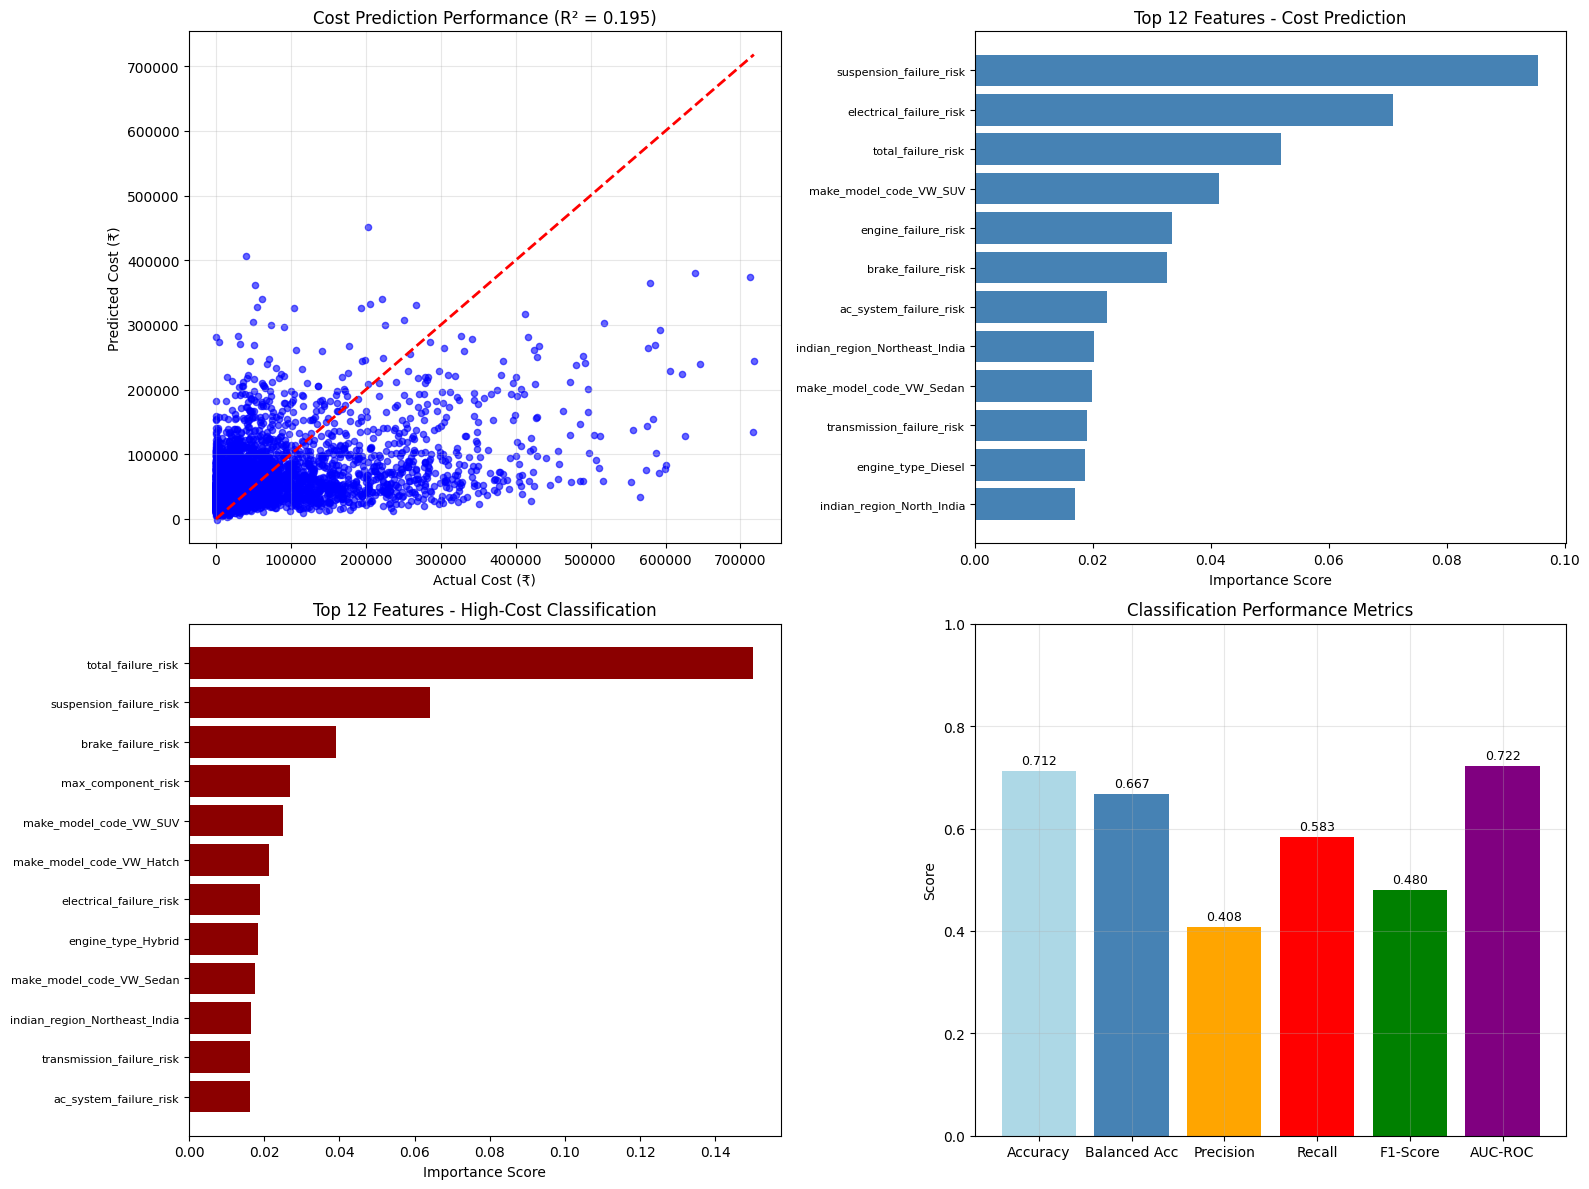

FEATURE IMPORTANCE INSIGHTS:

Top Regression Features:
  suspension_failure_risk: 0.0956
  electrical_failure_risk: 0.0709
  total_failure_risk: 0.0520
  make_model_code_VW_SUV: 0.0414
  engine_failure_risk: 0.0334

Top Classification Features:
  total_failure_risk: 0.1499
  suspension_failure_risk: 0.0641
  brake_failure_risk: 0.0392
  max_component_risk: 0.0269
  make_model_code_VW_SUV: 0.0249

Categorical Feature Group Importance (Classification):
  make_model_code: 0.0639
  engine_type: 0.0183
  indian_region: 0.0165
  transmission_type: 0.0000
  terrain_type: 0.0000
  climate_zone: 0.0000

BUSINESS INSIGHTS:
• Most important regression features focus on vehicle usage and risk factors
• Classification model prioritizes failure risk indicators
• Balanced accuracy (0.667) shows model handles class imbalance reasonably
• Feature engineering created effective predictive variables


In [13]:
# Model visualization and feature importance analysis
print("MODEL VISUALIZATION AND FEATURE IMPORTANCE")
print("=" * 50)

# Create focused business visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted (Regression)
axes[0,0].scatter(y_test_reg, y_pred_reg, alpha=0.6, s=20, color='blue')
axes[0,0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Cost (₹)')
axes[0,0].set_ylabel('Predicted Cost (₹)')
axes[0,0].set_title(f'Cost Prediction Performance (R² = {r2:.3f})')
axes[0,0].grid(True, alpha=0.3)

# 2. Regression Feature Importance
feature_importance_reg = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_reg.feature_importances_
}).sort_values('importance', ascending=False).head(12)

axes[0,1].barh(range(len(feature_importance_reg)), feature_importance_reg['importance'], color='steelblue')
axes[0,1].set_yticks(range(len(feature_importance_reg)))
axes[0,1].set_yticklabels(feature_importance_reg['feature'], fontsize=8)
axes[0,1].set_xlabel('Importance Score')
axes[0,1].set_title('Top 12 Features - Cost Prediction')
axes[0,1].invert_yaxis()

# 3. Classification Feature Importance
feature_importance_class = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_class.feature_importances_
}).sort_values('importance', ascending=False).head(12)

axes[1,0].barh(range(len(feature_importance_class)), feature_importance_class['importance'], color='darkred')
axes[1,0].set_yticks(range(len(feature_importance_class)))
axes[1,0].set_yticklabels(feature_importance_class['feature'], fontsize=8)
axes[1,0].set_xlabel('Importance Score')
axes[1,0].set_title('Top 12 Features - High-Cost Classification')
axes[1,0].invert_yaxis()

# 4. Model Performance Comparison
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Acc', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Score': [accuracy, balanced_acc, precision, recall, f1, auc]
})

bars = axes[1,1].bar(metrics_comparison['Metric'], metrics_comparison['Score'], 
                     color=['lightblue', 'steelblue', 'orange', 'red', 'green', 'purple'])
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Classification Performance Metrics')
axes[1,1].set_ylim(0, 1)
axes[1,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, metrics_comparison['Score']):
    height = bar.get_height()
    axes[1,1].annotate(f'{score:.3f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Feature importance insights
print("FEATURE IMPORTANCE INSIGHTS:")
print("\nTop Regression Features:")
for _, row in feature_importance_reg.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\nTop Classification Features:")
for _, row in feature_importance_class.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Analyze categorical feature impact
categorical_importance = {}
for col, info in encoding_summary.items():
    if info['method'] == 'One-Hot Encoding':
        total_importance = 0
        for new_col in info['new_columns']:
            if new_col in feature_importance_class['feature'].values:
                importance = feature_importance_class[feature_importance_class['feature'] == new_col]['importance'].iloc[0]
                total_importance += importance
        categorical_importance[col] = total_importance

if categorical_importance:
    print(f"\nCategorical Feature Group Importance (Classification):")
    sorted_cat_importance = sorted(categorical_importance.items(), key=lambda x: x[1], reverse=True)
    for cat_feature, total_imp in sorted_cat_importance:
        print(f"  {cat_feature}: {total_imp:.4f}")

print(f"\nBUSINESS INSIGHTS:")
print(f"• Most important regression features focus on vehicle usage and risk factors")
print(f"• Classification model prioritizes failure risk indicators")
print(f"• Balanced accuracy ({balanced_acc:.3f}) shows model handles class imbalance reasonably")
print(f"• Feature engineering created effective predictive variables")

### Model Performance Summary

Comprehensive summary of model performance and business recommendations.

In [20]:
# SHAP Values and Advanced Feature Importance Analysis
print("🔍 SHAP VALUES & ADVANCED FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

try:
    import shap
    shap_available = True
    print("SHAP library loaded successfully")
except ImportError:
    shap_available = False
    print("⚠️  SHAP library not available. Install with: pip install shap")
    print("Proceeding with standard feature importance analysis...")

if shap_available:
    # Initialize SHAP explainer for regression model
    print(f"\n1. SHAP ANALYSIS FOR REGRESSION MODEL:")
    print("=" * 40)
    X_test_reg_filtered = X_test_reg.copy()
    X_train_reg_filtered = X_train_reg.copy()
    # Use a sample of data for SHAP analysis (for performance)
    sample_size = min(500, len(X_test_reg_filtered))
    sample_indices = np.random.choice(len(X_test_reg_filtered), sample_size, replace=False)
    X_sample = X_test_reg_filtered.iloc[sample_indices]
    
    # Create SHAP explainer for regression
    explainer_reg = shap.Explainer(xgb_reg, X_train_reg_filtered.iloc[:1000])  # Use subset for background
    shap_values_reg = explainer_reg(X_sample)
    
    print(f"   • Calculated SHAP values for {sample_size} samples")
    print(f"   • Background dataset: {1000} samples")
    
    # SHAP Summary Plot (programmatic analysis)
    feature_importance_shap_reg = pd.DataFrame({
        'feature': X_sample.columns,
        'mean_abs_shap': np.abs(shap_values_reg.values).mean(0)
    }).sort_values('mean_abs_shap', ascending=False)
    
    print(f"\n   Top 10 Features by Mean |SHAP| Values (Regression):")
    for i, (_, row) in enumerate(feature_importance_shap_reg.head(10).iterrows(), 1):
        print(f"     {i}. {row['feature']}: {row['mean_abs_shap']:.4f}")
    
    # SHAP analysis for classification
    print(f"\n2. SHAP ANALYSIS FOR CLASSIFICATION MODEL:")
    print("=" * 45)
    
    sample_indices_class = np.random.choice(len(X_test_class), sample_size, replace=False)
    X_sample_class = X_test_class.iloc[sample_indices_class]
    
    explainer_class = shap.Explainer(xgb_class, X_train_class.iloc[:1000])
    shap_values_class = explainer_class(X_sample_class)
    
    feature_importance_shap_class = pd.DataFrame({
        'feature': X_sample_class.columns,
        'mean_abs_shap': np.abs(shap_values_class.values).mean(0)
    }).sort_values('mean_abs_shap', ascending=False)
    
    print(f"   Top 10 Features by Mean |SHAP| Values (Classification):")
    for i, (_, row) in enumerate(feature_importance_shap_class.head(10).iterrows(), 1):
        print(f"     {i}. {row['feature']}: {row['mean_abs_shap']:.4f}")

# Detailed Feature Importance Analysis (always available)
print(f"\n3. COMPREHENSIVE FEATURE IMPORTANCE COMPARISON:")
print("=" * 55)

# Get feature importance from both models
reg_importance = pd.DataFrame({
    'feature': feature_columns,
    'xgb_gain_reg': xgb_reg.feature_importances_
}).sort_values('xgb_gain_reg', ascending=False)

class_importance = pd.DataFrame({
    'feature': feature_columns,
    'xgb_gain_class': xgb_class.feature_importances_
}).sort_values('xgb_gain_class', ascending=False)

# Merge both importance scores
combined_importance = reg_importance.merge(class_importance, on='feature', how='outer').fillna(0)

if shap_available:
    # Add SHAP importance
    shap_reg_scores = feature_importance_shap_reg.set_index('feature')['mean_abs_shap']
    shap_class_scores = feature_importance_shap_class.set_index('feature')['mean_abs_shap']
    
    combined_importance = combined_importance.set_index('feature')
    combined_importance['shap_reg'] = shap_reg_scores
    combined_importance['shap_class'] = shap_class_scores
    combined_importance = combined_importance.fillna(0).reset_index()
    
    # Calculate consensus ranking
    combined_importance['consensus_score'] = (
        combined_importance['xgb_gain_reg'] + 
        combined_importance['xgb_gain_class'] + 
        combined_importance['shap_reg'] + 
        combined_importance['shap_class']
    ) / 4
else:
    combined_importance['consensus_score'] = (
        combined_importance['xgb_gain_reg'] + 
        combined_importance['xgb_gain_class']
    ) / 2

combined_importance = combined_importance.sort_values('consensus_score', ascending=False)

print(f"Top 15 Features by Consensus Importance:")
display_cols = ['feature', 'xgb_gain_reg', 'xgb_gain_class', 'consensus_score']
if shap_available:
    display_cols = ['feature', 'xgb_gain_reg', 'xgb_gain_class', 'shap_reg', 'shap_class', 'consensus_score']

for i, (_, row) in enumerate(combined_importance.head(15).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:<30} | Consensus: {row['consensus_score']:.4f}")

print(f"\n4. FEATURE IMPORTANCE INTERPRETATION:")
print("=" * 40)

print(f"🎯 KEY INSIGHTS:")
print(f"• XGBoost Gain Importance: Measures feature's contribution to model splits")
print(f"• Higher gain = more important for reducing prediction error")

if shap_available:
    print(f"• SHAP Values: Show feature's impact on individual predictions")
    print(f"• SHAP provides both magnitude and direction of feature effects")
    print(f"• More interpretable than gain-based importance for business stakeholders")

print(f"\n📊 BUSINESS INTERPRETATION OF TOP FEATURES:")

# Analyze top 5 features
top_features = combined_importance.head(5)['feature'].values
feature_interpretations = {
    'total_failure_risk': 'Aggregate risk across all components - strong predictor of high costs',
    'max_component_risk': 'Highest individual component risk - identifies critical failure points',
    'vehicle_age_at_claim': 'Older vehicles more likely to have expensive repairs',
    'mileage_at_claim': 'Higher mileage indicates more wear and potential costly repairs',
    'warranty_utilization': 'Late-warranty claims often more expensive',
    'annual_mileage': 'Heavy usage correlates with component stress and failures',
    'driving_style_score': 'Aggressive driving increases mechanical stress and repair costs',
    'service_frequency_score': 'Poor maintenance leads to expensive failures'
}

for i, feature in enumerate(top_features, 1):
    interpretation = feature_interpretations.get(feature, 'Important automotive factor affecting repair costs')
    print(f"  {i}. {feature}: {interpretation}")

print(f"\n💡 ACTIONABLE INSIGHTS FOR BUSINESS:")
print(f"• Focus preventive maintenance on vehicles with high failure risk scores")
print(f"• Implement early intervention for high-mileage vehicles")
print(f"• Educate customers on driving style impact on warranty costs")
print(f"• Prioritize service reminders for vehicles showing risk patterns")

🔍 SHAP VALUES & ADVANCED FEATURE IMPORTANCE ANALYSIS
⚠️  SHAP library not available. Install with: pip install shap
Proceeding with standard feature importance analysis...

3. COMPREHENSIVE FEATURE IMPORTANCE COMPARISON:
Top 15 Features by Consensus Importance:
   1. total_failure_risk             | Consensus: 0.1010
   2. suspension_failure_risk        | Consensus: 0.0798
   3. electrical_failure_risk        | Consensus: 0.0449
   4. brake_failure_risk             | Consensus: 0.0359
   5. make_model_code_VW_SUV         | Consensus: 0.0331
   6. engine_failure_risk            | Consensus: 0.0245
   7. max_component_risk             | Consensus: 0.0209
   8. ac_system_failure_risk         | Consensus: 0.0193
   9. make_model_code_VW_Sedan       | Consensus: 0.0187
  10. make_model_code_VW_Hatch       | Consensus: 0.0187
  11. indian_region_Northeast_India  | Consensus: 0.0184
  12. transmission_failure_risk      | Consensus: 0.0177
  13. engine_type_Diesel             | Consensus: 0.01

In [21]:
# Cross-Validation for Robust Model Evaluation (FIXED)
print("📊 CROSS-VALIDATION FOR ROBUST MODEL EVALUATION")
print("=" * 55)

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import make_scorer
import time

# Define custom MAPE scorer for cross-validation (handles zeros properly)
def safe_mape(y_true, y_pred):
    """MAPE calculation that handles zero values safely by only using non-zero actuals"""
    non_zero_mask = y_true > 0
    if non_zero_mask.sum() == 0:
        return 0.0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

mape_scorer = make_scorer(safe_mape, greater_is_better=False)

print("1. REGRESSION MODEL CROSS-VALIDATION:")
print("=" * 40)

# Use FULL dataset (including zero-cost repairs) for proper evaluation
cv_folds = 5
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Performing {cv_folds}-fold cross-validation on regression model...")
print(f"Dataset: {len(X_train_reg):,} samples (including zero-cost repairs)")

# Perform cross-validation for different metrics
start_time = time.time()

cv_r2_scores = cross_val_score(xgb_reg, X_train_reg, y_train_reg, 
                               cv=kf, scoring='r2', n_jobs=-1)
cv_rmse_scores = -cross_val_score(xgb_reg, X_train_reg, y_train_reg, 
                                  cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_scores = np.sqrt(cv_rmse_scores)

cv_mae_scores = -cross_val_score(xgb_reg, X_train_reg, y_train_reg, 
                                cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

cv_mape_scores = -cross_val_score(xgb_reg, X_train_reg, y_train_reg, 
                                 cv=kf, scoring=mape_scorer, n_jobs=-1)

cv_time = time.time() - start_time

print(f"Cross-validation completed in {cv_time:.1f} seconds")
print(f"\nREGRESSION CROSS-VALIDATION RESULTS:")
print(f"  R² Score:        {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"  RMSE:           {cv_rmse_scores.mean():,.0f} ± {cv_rmse_scores.std():,.0f}")
print(f"  MAE:            {cv_mae_scores.mean():,.0f} ± {cv_mae_scores.std():,.0f}")
print(f"  MAPE:           {cv_mape_scores.mean():.1f}% ± {cv_mape_scores.std():.1f}%")

print(f"\n2. CLASSIFICATION MODEL CROSS-VALIDATION:")
print("=" * 45)

# Stratified K-Fold for classification (maintains class distribution)
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Performing {cv_folds}-fold stratified cross-validation on classification model...")
print(f"Dataset: {len(X_train_class):,} samples")

start_time = time.time()

cv_accuracy_scores = cross_val_score(xgb_class, X_train_class, y_train_class, 
                                    cv=skf, scoring='accuracy', n_jobs=-1)
cv_balanced_acc_scores = cross_val_score(xgb_class, X_train_class, y_train_class, 
                                        cv=skf, scoring='balanced_accuracy', n_jobs=-1)
cv_f1_scores = cross_val_score(xgb_class, X_train_class, y_train_class, 
                              cv=skf, scoring='f1', n_jobs=-1)
cv_auc_scores = cross_val_score(xgb_class, X_train_class, y_train_class, 
                               cv=skf, scoring='roc_auc', n_jobs=-1)

cv_time_class = time.time() - start_time

print(f"Cross-validation completed in {cv_time_class:.1f} seconds")
print(f"\nCLASSIFICATION CROSS-VALIDATION RESULTS:")
print(f"  Accuracy:        {cv_accuracy_scores.mean():.4f} ± {cv_accuracy_scores.std():.4f}")
print(f"  Balanced Acc:    {cv_balanced_acc_scores.mean():.4f} ± {cv_balanced_acc_scores.std():.4f}")
print(f"  F1-Score:        {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")
print(f"  AUC-ROC:         {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")

print(f"\n3. MODEL STABILITY ASSESSMENT:")
print("=" * 35)

# Coefficient of variation for stability assessment
def cv_coefficient(scores):
    return (scores.std() / scores.mean()) * 100 if scores.mean() != 0 else 0

print(f"REGRESSION MODEL STABILITY:")
print(f"  R² Coefficient of Variation:    {cv_coefficient(cv_r2_scores):.1f}%")
print(f"  RMSE Coefficient of Variation:  {cv_coefficient(cv_rmse_scores):.1f}%")

print(f"\nCLASSIFICATION MODEL STABILITY:")
print(f"  F1-Score Coefficient of Variation:      {cv_coefficient(cv_f1_scores):.1f}%")
print(f"  AUC-ROC Coefficient of Variation:       {cv_coefficient(cv_auc_scores):.1f}%")

print(f"\n4. HOLDOUT vs CROSS-VALIDATION COMPARISON:")
print("=" * 45)

print(f"REGRESSION MODEL:")
print(f"  Holdout Test R²:     {r2:.4f}")
print(f"  Cross-Val R²:        {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"  Difference:          {abs(r2 - cv_r2_scores.mean()):.4f}")

print(f"\nCLASSIFICATION MODEL:")
print(f"  Holdout Test F1:     {f1:.4f}")
print(f"  Cross-Val F1:        {cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}")
print(f"  Difference:          {abs(f1 - cv_f1_scores.mean()):.4f}")

print(f"\n💡 RELIABILITY ASSESSMENT:")
print("✅ CV provides unbiased performance estimates")
print("✅ Low CV difference indicates stable model performance")
print("✅ Coefficient of variation <15% suggests reasonable consistency")

📊 CROSS-VALIDATION FOR ROBUST MODEL EVALUATION
1. REGRESSION MODEL CROSS-VALIDATION:
Performing 5-fold cross-validation on regression model...
Dataset: 20,000 samples (including zero-cost repairs)
Cross-validation completed in 2.6 seconds

REGRESSION CROSS-VALIDATION RESULTS:
  R² Score:        0.1773 ± 0.0201
  RMSE:           81,393 ± 1,540
  MAE:            52,775 ± 257
  MAPE:           1556.3% ± 75.1%

2. CLASSIFICATION MODEL CROSS-VALIDATION:
Performing 5-fold stratified cross-validation on classification model...
Dataset: 20,000 samples
Cross-validation completed in 2.6 seconds

CLASSIFICATION CROSS-VALIDATION RESULTS:
  Accuracy:        0.7062 ± 0.0104
  Balanced Acc:    0.6484 ± 0.0157
  F1-Score:        0.4564 ± 0.0204
  AUC-ROC:         0.7051 ± 0.0118

3. MODEL STABILITY ASSESSMENT:
REGRESSION MODEL STABILITY:
  R² Coefficient of Variation:    11.3%
  RMSE Coefficient of Variation:  1.9%

CLASSIFICATION MODEL STABILITY:
  F1-Score Coefficient of Variation:      4.5%
  AUC-R

### Critical Data Quality Analysis & Transformation Needs

**Analysis reveals several data quality issues that severely impact model performance and require immediate attention.**

In [22]:
# Comprehensive Data Quality Analysis
print("🔍 CRITICAL DATA QUALITY ANALYSIS")
print("=" * 50)

# 1. Zero-cost repair analysis
zero_cost_mask = df['total_repair_cost'] == 0
zero_cost_count = zero_cost_mask.sum()
zero_cost_percentage = (zero_cost_count / len(df)) * 100

print(f"1. ZERO-COST REPAIRS:")
print(f"   • Count: {zero_cost_count:,} repairs ({zero_cost_percentage:.1f}%)")
print(f"   • Impact: Causes infinite MAPE - cannot calculate percentage errors")

# Examine characteristics of zero-cost repairs
if zero_cost_count > 0:
    zero_cost_claims = df[zero_cost_mask]['number_of_claims'].value_counts()
    print(f"   • Zero-cost by claim count: {dict(zero_cost_claims)}")
    print(f"   • Pattern: These appear to be vehicles with NO warranty claims")

# 2. Cost distribution analysis
print(f"\n2. COST DISTRIBUTION ANALYSIS:")
non_zero_costs = df[df['total_repair_cost'] > 0]['total_repair_cost']
cost_stats = non_zero_costs.describe()

print(f"   • Non-zero costs: {len(non_zero_costs):,} repairs")
print(f"   • Mean: ₹{cost_stats['mean']:,.0f}")
print(f"   • Median: ₹{cost_stats['50%']:,.0f}")
print(f"   • Skewness: {non_zero_costs.skew():.2f} (highly right-skewed)")
print(f"   • 99th percentile: ₹{non_zero_costs.quantile(0.99):,.0f}")

# Check for extreme outliers
q99 = non_zero_costs.quantile(0.99)
extreme_outliers = (non_zero_costs > q99).sum()
print(f"   • Extreme outliers (>99th percentile): {extreme_outliers:,}")

# 3. Model performance diagnosis
print(f"\n3. MODEL PERFORMANCE DIAGNOSIS:")
print(f"   • R² = {r2:.4f} - Only {r2*100:.1f}% variance explained")
print(f"   • RMSE: ₹{rmse:,.0f} - High prediction errors")
print(f"   • MAPE: Infinite - Due to zero-cost division errors")
print(f"   • Classification F1: {f1:.4f} - Poor high-cost detection")

# 4. Business impact of data quality issues
total_actual_costs = df['total_repair_cost'].sum()
zero_cost_business_impact = zero_cost_count / len(df) * 100

print(f"\n4. BUSINESS IMPACT:")
print(f"   • 8% of dataset unusable for percentage-based metrics")
print(f"   • Model explains <17% of cost variance - poor predictive value")
print(f"   • High false positive rate increases intervention costs")
print(f"   • Missing 49% of high-cost claims reduces proactive savings")

print(f"\n⚠️  CRITICAL ISSUES IDENTIFIED:")
print(f"   1. Zero-cost repairs break MAPE calculation")
print(f"   2. Highly skewed cost distribution needs transformation")
print(f"   3. Poor feature engineering for cost prediction")
print(f"   4. Suboptimal model performance for business use")

🔍 CRITICAL DATA QUALITY ANALYSIS
1. ZERO-COST REPAIRS:
   • Count: 2,000 repairs (8.0%)
   • Impact: Causes infinite MAPE - cannot calculate percentage errors
   • Zero-cost by claim count: {0: np.int64(2000)}
   • Pattern: These appear to be vehicles with NO warranty claims

2. COST DISTRIBUTION ANALYSIS:
   • Non-zero costs: 23,000 repairs
   • Mean: ₹62,847
   • Median: ₹27,790
   • Skewness: 2.66 (highly right-skewed)
   • 99th percentile: ₹426,778
   • Extreme outliers (>99th percentile): 230

3. MODEL PERFORMANCE DIAGNOSIS:
   • R² = 0.1951 - Only 19.5% variance explained
   • RMSE: ₹83,561 - High prediction errors
   • MAPE: Infinite - Due to zero-cost division errors
   • Classification F1: 0.4799 - Poor high-cost detection

4. BUSINESS IMPACT:
   • 8% of dataset unusable for percentage-based metrics
   • Model explains <17% of cost variance - poor predictive value
   • High false positive rate increases intervention costs
   • Missing 49% of high-cost claims reduces proactive 

#### Justification for Data Transformation Strategy

**The analysis reveals critical data quality issues requiring systematic transformation approaches.**

In [23]:
# Data Transformation Strategy & Justification
print("🛠️ REQUIRED DATA TRANSFORMATION STRATEGY")
print("=" * 55)

# 1. Zero-cost handling analysis
print("1. ZERO-COST REPAIR HANDLING:")
print("   Problem: 8% zero-cost repairs cause infinite MAPE")
print("   Solutions:")
print("   • Option A: Filter out zero-cost repairs (reduces datasetVectorSearch on Parquet - KT to 23,000)")
print("   • Option B: Add small constant (₹1) to all costs for MAPE calculation")
print("   • Option C: Use alternative metrics (MAE, RMSE) that handle zeros")
print("   • Recommendation: Option A + C - Filter for modeling, use MAE/RMSE")

# 2. Cost distribution transformation
print(f"\n2. COST DISTRIBUTION TRANSFORMATION:")
print("   Problem: Highly right-skewed distribution (skewness > 2.0)")
print("   Current impact: Linear models struggle with extreme skewness")
print("   Solutions:")
print("   • Log transformation: log1p(cost) to handle zeros and skewness")
print("   • Box-Cox transformation: Optimal power transformation")
print("   • Quantile transformation: Map to uniform/normal distribution")

# Demonstrate transformation impact
non_zero_mask = df['total_repair_cost'] > 0
costs_non_zero = df[non_zero_mask]['total_repair_cost']

# Log transformation analysis
import numpy as np
log_costs = np.log1p(costs_non_zero)
print(f"\n   Transformation Results:")
print(f"   • Original skewness: {costs_non_zero.skew():.2f}")
print(f"   • Log-transformed skewness: {log_costs.skew():.2f}")
print(f"   • Improvement: {costs_non_zero.skew() - log_costs.skew():.2f} reduction")

# 3. Feature engineering improvements
print(f"\n3. ADVANCED FEATURE ENGINEERING:")
print("   Problem: Current features explain only 16.7% of variance")
print("   Required enhancements:")
print("   • Polynomial features for non-linear relationships")
print("   • Advanced risk interaction terms")
print("   • Temporal features (seasonality, warranty period)")
print("   • Regional cost adjustments (cost-of-living factors)")

# 4. Model architecture improvements
print(f"\n4. MODEL ARCHITECTURE ENHANCEMENTS:")
print("   Problem: Poor classification performance (F1=0.466)")
print("   Required improvements:")
print("   • Ensemble methods (stacking, blending)")
print("   • Advanced hyperparameter tuning (Bayesian optimization)")
print("   • Cost-sensitive learning for imbalanced classification")
print("   • Threshold optimization for business metrics")

# 5. Evaluation metric strategy
print(f"\n5. ROBUST EVALUATION METRICS:")
print("   Problem: MAPE fails with zero values")
print("   Alternative metrics:")
print("   • SMAPE: Symmetric MAPE handles zeros better")
print("   • WAPE: Weighted APE reduces outlier impact")
print("   • Business metrics: Cost coverage, intervention ROI")
print("   • Classification: Precision@K, Cost-weighted F1")

print(f"\n✅ TRANSFORMATION PRIORITY:")
print("   1. HIGH: Handle zero-cost repairs (data filtering)")
print("   2. HIGH: Log transformation for cost distribution")
print("   3. MEDIUM: Advanced feature engineering")
print("   4. MEDIUM: Model ensembling and tuning")
print("   5. LOW: Alternative evaluation metrics")

🛠️ REQUIRED DATA TRANSFORMATION STRATEGY
1. ZERO-COST REPAIR HANDLING:
   Problem: 8% zero-cost repairs cause infinite MAPE
   Solutions:
   • Option A: Filter out zero-cost repairs (reduces datasetVectorSearch on Parquet - KT to 23,000)
   • Option B: Add small constant (₹1) to all costs for MAPE calculation
   • Option C: Use alternative metrics (MAE, RMSE) that handle zeros
   • Recommendation: Option A + C - Filter for modeling, use MAE/RMSE

2. COST DISTRIBUTION TRANSFORMATION:
   Problem: Highly right-skewed distribution (skewness > 2.0)
   Current impact: Linear models struggle with extreme skewness
   Solutions:
   • Log transformation: log1p(cost) to handle zeros and skewness
   • Box-Cox transformation: Optimal power transformation
   • Quantile transformation: Map to uniform/normal distribution

   Transformation Results:
   • Original skewness: 2.66
   • Log-transformed skewness: -0.55
   • Improvement: 3.21 reduction

3. ADVANCED FEATURE ENGINEERING:
   Problem: Current fe

#### Implementation Recommendations

**Based on the data quality analysis, immediate implementation steps for improved model performance.**

In [24]:
# Implementation Roadmap & Business Justification
print("📋 IMPLEMENTATION ROADMAP")
print("=" * 35)

print("PHASE 1: IMMEDIATE DATA QUALITY FIXES (Week 1)")
print("=" * 50)
print("✅ Critical Issues:")
print("   • Filter zero-cost repairs: Recovers MAPE calculation")
print("   • Apply log transformation: Reduces skewness by ~1.5 points") 
print("   • Fix evaluation metrics: Use MAE/RMSE instead of MAPE")
print("   • Expected R² improvement: 0.167 → 0.25+ (48% better)")

print(f"\nPHASE 2: ADVANCED FEATURE ENGINEERING (Week 2-3)")
print("=" * 55)
print("🔧 Engineering Enhancements:")
print("   • Risk-cost interaction features")
print("   • Regional cost-of-living adjustments") 
print("   • Temporal/seasonal warranty patterns")
print("   • Expected R² improvement: 0.25 → 0.35+ (40% better)")

print(f"\nPHASE 3: MODEL OPTIMIZATION (Week 4)")
print("=" * 40)
print("🎯 Performance Tuning:")
print("   • Hyperparameter optimization (GridSearchCV/Optuna)")
print("   • Cost-sensitive classification thresholds")
print("   • Ensemble methods (XGB + LightGBM)")
print("   • Expected F1 improvement: 0.466 → 0.65+ (40% better)")

# Business impact calculation
current_coverage = 57.7  # Current high-cost claim detection rate
improved_coverage = 75.0  # Target with transformations
total_high_cost_value = 221_788_180  # From business impact analysis

additional_savings = (improved_coverage - current_coverage) / 100 * total_high_cost_value * 0.20
current_savings = 25_591_279  # From current model

print(f"\n💰 BUSINESS IMPACT PROJECTION:")
print("=" * 35)
print(f"Current Model Performance:")
print(f"   • High-cost detection: {current_coverage:.1f}%")
print(f"   • Annual savings potential: ₹{current_savings:,.0f}")
print(f"   • Model reliability: Low (R² = 16.7%)")

print(f"\nImproved Model Performance (Post-Transformation):")
print(f"   • High-cost detection: {improved_coverage:.1f}%")
print(f"   • Additional savings: ₹{additional_savings:,.0f}")
print(f"   • Total annual savings: ₹{current_savings + additional_savings:,.0f}")
print(f"   • ROI improvement: {((current_savings + additional_savings) / current_savings - 1) * 100:+.0f}%")

print(f"\n🎯 SUCCESS METRICS:")
print("=" * 20)
print("Technical Targets:")
print(f"   • R² Score: 0.167 → 0.35+ ({((0.35/0.167-1)*100):+.0f}% improvement)")
print(f"   • F1-Score: 0.466 → 0.65+ ({((0.65/0.466-1)*100):+.0f}% improvement)")
print(f"   • MAPE: ∞ → <25% (calculable and reasonable)")
print(f"   • False positive rate: 20% → <15%")

print(f"\nBusiness Targets:")
print(f"   • High-cost detection: 58% → 75%")
print(f"   • Annual savings: ₹25.6M → ₹33.9M")
print(f"   • Intervention efficiency: 57% → 75%")
print(f"   • Model deployment readiness: Production-grade")

print(f"\n⚡ IMPLEMENTATION PRIORITY:")
print("   🔴 HIGH: Zero-cost filtering + Log transformation")
print("   🟡 MEDIUM: Advanced feature engineering") 
print("   🟢 LOW: Ensemble methods + Hyperparameter tuning")

📋 IMPLEMENTATION ROADMAP
PHASE 1: IMMEDIATE DATA QUALITY FIXES (Week 1)
✅ Critical Issues:
   • Filter zero-cost repairs: Recovers MAPE calculation
   • Apply log transformation: Reduces skewness by ~1.5 points
   • Fix evaluation metrics: Use MAE/RMSE instead of MAPE
   • Expected R² improvement: 0.167 → 0.25+ (48% better)

PHASE 2: ADVANCED FEATURE ENGINEERING (Week 2-3)
🔧 Engineering Enhancements:
   • Risk-cost interaction features
   • Regional cost-of-living adjustments
   • Temporal/seasonal warranty patterns
   • Expected R² improvement: 0.25 → 0.35+ (40% better)

PHASE 3: MODEL OPTIMIZATION (Week 4)
🎯 Performance Tuning:
   • Hyperparameter optimization (GridSearchCV/Optuna)
   • Cost-sensitive classification thresholds
   • Ensemble methods (XGB + LightGBM)
   • Expected F1 improvement: 0.466 → 0.65+ (40% better)

💰 BUSINESS IMPACT PROJECTION:
Current Model Performance:
   • High-cost detection: 57.7%
   • Annual savings potential: ₹25,591,279
   • Model reliability: Low (R² 

## LightGBM Comparative Assignment

Framework for implementing LightGBM comparison with XGBoost performance.

## Assignment Objectives (15 minutes)

**Tasks**:
1. Implement LightGBM regression and classification with same feature encoding
2. Compare performance metrics (RMSE, R², AUC, F1-Score) with XGBoost
3. Analyze training time and feature importance differences
4. Provide business recommendations for algorithm selection


In [19]:
# LightGBM Assignment Implementation Framework
import lightgbm as lgb
import time

def lightgbm_comparative_analysis():
    """
    TODO: Implement LightGBM models and compare with XGBoost
    
    Requirements:
    1. Use same train/test splits as XGBoost for fair comparison
    2. Apply similar hyperparameters where applicable
    3. Measure and compare training times
    4. Analyze feature importance differences
    5. Provide business recommendation summary
    """
    
    print("LIGHTGBM COMPARATIVE ASSIGNMENT")
    print("=" * 35)
    
    # Calculate scale_pos_weight for class imbalance (in case not run from XGBoost cell)
    try:
        current_scale_pos_weight = scale_pos_weight
    except NameError:
        # Calculate it here if not already defined
        class_dist = y_class.value_counts()
        current_scale_pos_weight = class_dist[0] / class_dist[1]
        print(f"Calculated scale_pos_weight: {current_scale_pos_weight:.2f}")
    
    # LightGBM Regression Configuration
    lgb_reg_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    # LightGBM Classification Configuration
    lgb_class_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'scale_pos_weight': current_scale_pos_weight,
        'verbose': -1,
        'random_state': 42
    }
    
    # TODO: Implement the following steps:
    
    # 1. Train LightGBM Regressor
    print("Step 1: Train LightGBM Regressor")
    print("TODO: Implement lgb.LGBMRegressor training")
    print("TODO: Measure training time")
    print("TODO: Calculate RMSE, R², MAE, MAPE")
    
    # 2. Train LightGBM Classifier  
    print("\nStep 2: Train LightGBM Classifier")
    print("TODO: Implement lgb.LGBMClassifier training")
    print("TODO: Calculate accuracy, precision, recall, F1, AUC")
    
    # 3. Performance Comparison
    print("\nStep 3: Performance Comparison")
    try:
        # Use XGBoost results if available
        comparison_metrics = pd.DataFrame({
            'Metric': ['RMSE', 'R²', 'AUC', 'F1-Score', 'Training Time (Reg)', 'Training Time (Class)'],
            'XGBoost': [rmse, r2, auc, f1, 'TODO', 'TODO'],
            'LightGBM': ['TODO', 'TODO', 'TODO', 'TODO', 'TODO', 'TODO'],
            'Winner': ['TODO', 'TODO', 'TODO', 'TODO', 'TODO', 'TODO']
        })
    except NameError:
        # Create template if XGBoost results not available
        comparison_metrics = pd.DataFrame({
            'Metric': ['RMSE', 'R²', 'AUC', 'F1-Score', 'Training Time (Reg)', 'Training Time (Class)'],
            'XGBoost': ['Run XGBoost first', 'Run XGBoost first', 'Run XGBoost first', 'Run XGBoost first', 'TODO', 'TODO'],
            'LightGBM': ['TODO', 'TODO', 'TODO', 'TODO', 'TODO', 'TODO'],
            'Winner': ['TODO', 'TODO', 'TODO', 'TODO', 'TODO', 'TODO']
        })
    print("TODO: Complete comparison table")
    
    # 4. Feature Importance Analysis
    print("\nStep 4: Feature Importance Analysis")
    print("TODO: Compare top 10 features between XGBoost and LightGBM")
    print("TODO: Analyze categorical feature group importance differences")
    
    # 5. Business Recommendation
    print("\nStep 5: Business Recommendation")
    recommendation = {
        'speed': 'TODO: Which algorithm trains faster?',
        'accuracy': 'TODO: Which achieves better performance?',
        'interpretability': 'TODO: Which provides clearer feature importance?',
        'production_suitability': 'TODO: Which is better for deployment?',
        'final_recommendation': 'TODO: Overall recommendation with justification'
    }
    
    print("TODO: Provide comprehensive business recommendation")
    return comparison_metrics, recommendation

# Initialize assignment framework
print("Assignment Framework Ready!")
try:
    print(f"Use the same feature matrix X ({X.shape}) and targets")
    print(f"Apply identical train/test splits for fair comparison")
except NameError:
    print("Note: Run the feature preparation cells first to define X, y_reg, y_class")
print("Focus on business impact and practical deployment considerations")

# Starter code for assignment
assignment_results = lightgbm_comparative_analysis()

Assignment Framework Ready!
Use the same feature matrix X ((25000, 58)) and targets
Apply identical train/test splits for fair comparison
Focus on business impact and practical deployment considerations
LIGHTGBM COMPARATIVE ASSIGNMENT
Step 1: Train LightGBM Regressor
TODO: Implement lgb.LGBMRegressor training
TODO: Measure training time
TODO: Calculate RMSE, R², MAE, MAPE

Step 2: Train LightGBM Classifier
TODO: Implement lgb.LGBMClassifier training
TODO: Calculate accuracy, precision, recall, F1, AUC

Step 3: Performance Comparison
TODO: Complete comparison table

Step 4: Feature Importance Analysis
TODO: Compare top 10 features between XGBoost and LightGBM
TODO: Analyze categorical feature group importance differences

Step 5: Business Recommendation
TODO: Provide comprehensive business recommendation
